## Interpolation Module

## Introduction
To simulate Daedalus measurments using physics based model such as TIEGCM 
values of gridded data have to be interpolateds to the spacecraft's positions.In
Daedalus Maze this is provided by the Interpolation Module which is described below.

The Interpolation Module consists of a family of  codes written in python FORTRAN and C++.

## Basic Input and Output
The Interpolation Module supports Dedalus Input orbits in netcdf format and exports the interpolation
results in netcdf as well.

## Performance and Parallelization Level
The python version of the Inteprolation Modules supports single threaded and multi threaded workloads using the multiprocessing library. At the same, the user can opt to call the pre-compiled low-level FORTRAN subroutines which can handle both the single threaded and the multi threaded interpolations using OpenMP.

The C++ version, uses the OpenMPI and OpenMP interface and can support massive scalability on distributed memory using hybrid programming,splitting the interpolations in threads and nodes.The same basic input and output interface is used as with the python version.

Finally there is a version of the Interpolation Module written in C++ using a CUDA kernel to speed up the interpolation process. On a shared memory environment this is by far the fastest version, outperforming the 
python version by more than three orders of magnitude.






## Skeleton of the Interpolation Module


## The Model Class: 
This class handles basic IO of the Model Data extracting grid quintities and variables as selected by
the user to be used in the interpolation.


In [1]:
from netCDF4 import Dataset
import matplotlib.pyplot as plt
%matplotlib inline  
import pandas as pd
import numpy as np
import pandas as pd
from pandas import DataFrame
from datetime import datetime
import time
import os
import sys
import multiprocessing
from functools import partial
from scipy.signal import savgol_filter
import warnings
warnings.filterwarnings('ignore')

startTime = 0

In [2]:

class Model:
    def __init__(self,name, maxAltitude, minAltitude):
        self.name=name
        self.maxAltitude=maxAltitude
        self.minAltitude=minAltitude
        self.dt=0.0



    def readGrid(self,name):
        TIEGCM=Dataset(name+".nc")
        glat=TIEGCM.variables['lat'][:]
        glon=TIEGCM.variables['lon'][:]
        glev=TIEGCM.variables['lev'][:]
        gtime=TIEGCM.variables['time'][:] 
        zg=TIEGCM.variables['ZGMID'][:]
        TIEGCM.close()
        self.dt= gtime[2]- gtime[1]
       
        return np.asarray(gtime),np.asarray(glat),np.asarray(glon),np.asarray(glev),np.asarray(zg)

    def readVar(self,model,name):
        TIEGCM=Dataset(model+".nc")
        var=TIEGCM.variables[name][:]
        TIEGCM.close()
        return var


## The Orbit Class: 
This class  This class handles basic IO of Daedalus' orbit allocating arrays for the spatial components. The longitudinal component is matched to TIEGCM's  and points in a specific altitudinal range are extracted to be passed to the interpolation routine. There is also an option for creating a Rocket orbit for getting 
vertical profiles of the said model.

In [3]:

class Orbit:
    def __init__(self,name):
        self.name=name
        self.dt=1/16



    def createorbit(self,filename,minAlt,maxAlt,outfile,Save=False):
        orbit=Dataset(filename+".nc","r")
        daed_lat_temp = orbit.variables['lat'][:]
        daed_lon_temp = orbit.variables['lon'][:]
        daed_alt_temp = orbit.variables['altitude'][:]
        daed_time_temp = orbit.variables['time'][:] #unix time
        
        global startTime
        startTime = daed_time_temp[0]
        

#         self.dt=daed_time_temp[2]-daed_time_temp[1]
        self.Save=Save
        
        if self.Save==True:
            self.OpenFile(outfile,daed_time_temp,daed_lat_temp,daed_lon_temp,daed_alt_temp)
        
        stop=False
        counter=0
        for i in range(0,len(daed_alt_temp)):
            if (daed_alt_temp[i] < maxAlt and daed_alt_temp[i] > minAlt):
                counter=counter+1

        
        
        daed_lat=np.zeros((counter))
        daed_lon=np.zeros((counter))
        daed_alt=np.zeros((counter))
        daed_time=np.zeros((counter),dtype=datetime)
        index=[None]*counter
        int_final=[None]*len(daed_alt_temp)


   
        counter2=0
        
        for i in range(0,len(daed_alt_temp)):
    
            if (daed_alt_temp[i] < maxAlt and daed_alt_temp[i] > minAlt):
         
                daed_time[counter2]=daed_time_temp[i]
                daed_lat[counter2]=daed_lat_temp[i]
                if max(daed_lon_temp)>180:
                    daed_lon[counter2]=daed_lon_temp[i]-180 #match TIEGCM grid
                else:
                    daed_lon[counter2]=daed_lon_temp[i]
                daed_alt[counter2]=daed_alt_temp[i]
                
                index[counter2]=i          #keep indices for merging data
                counter2=counter2+1
        

        return(daed_time,daed_lat,daed_lon,daed_alt,index,int_final)

    def RockeOrbit(self,lat,lon,alt,nop,dz):
        Rlat=np.zeros(nop)
        Rlon=np.zeros(nop)
        Ralt=np.zeros(nop)

        Rlat[:]=lat
        Rlon[:]=lon
        Ralt[0]=alt
        for i in range(1,nop):
            Ralt[i]=Ralt[i-1]+dz

        return Rlat,Rlon,Ralt

    def mergeData(self,index,int_final,m):
        for i in range(0,len(m)):
            int_final[index[i]]=m[i]

        return int_final    



    def OpenFile(self,outfile,time,lat,lon,alt):
        print("Output File Path:",outfile)
        ncout = Dataset(outfile, "w", format="NETCDF4")    
        ncout.createDimension("time", len(time))
        xaxis=np.arange(0,len(time)) #time axis based on Daedalus Sampling rate
        data = ncout.createVariable("time","f4","time")
        data[:]=xaxis
        ncout.createDimension("lat",len(lat))
        data = ncout.createVariable("lat","f4","lat")
        data[:]=lat
        ncout.createDimension("lon",len(lon))
        data = ncout.createVariable("lon","f4","lon")
        data[:]=lon
        ncout.createDimension("altitude",len(alt))
        data = ncout.createVariable("altitude","f4","time")
        data[:]=alt
        ncout.close()   
        return True



Functions used by the Interpolation Module
The geod2geo_lat converts geodetic latitude to geographic latitude

In [4]:
def geod_lat2geo_lat(phi):

    # calculate geocentric latitude from geodetic latitude
    # according to WGS 84
    a = 6378137  # meter semi major axis of earth
    f = 1 / 298.257  # flattening
    b = a - f * a  # semi minor axis
    e = ((a ** 2 - b ** 2) ** (1 / 2)) / a
    phi_rad = np.deg2rad(phi)
    geo_lat = np.arctan((1 - e ** 2) * np.tan(phi_rad))
    geo_lat = np.rad2deg(geo_lat)
    return geo_lat  # in degrees

The function local is used to find the local neighbors of a specific component in a non eqwually spaced array 
such as the pressure levels in the TIEGCM

In [5]:

def local(dim1,y,x):
    local_pos=0
    for i in range(0,len(x)-1):
        if y >= x[i] and y < x[i+1]:
            local_pos=i
            return (local_pos)
    return (local_pos)

The following functions are used on order to calculate first,second and thrird order partial derivatives. Moreover table "A" carries Tricubic Spline Coefficients.

In [6]:
A = [
[ 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[ 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[-3, 3, 0, 0, 0, 0, 0, 0,-2,-1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[ 2,-2, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,-3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,-2,-1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2,-2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[-3, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,-2, 0,-1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[ 0, 0, 0, 0, 0, 0, 0, 0,-3, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,-2, 0,-1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[ 9,-9,-9, 9, 0, 0, 0, 0, 6, 3,-6,-3, 0, 0, 0, 0, 6,-6, 3,-3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 2, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[-6, 6, 6,-6, 0, 0, 0, 0,-3,-3, 3, 3, 0, 0, 0, 0,-4, 4,-2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,-2,-2,-1,-1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[ 2, 0,-2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[ 0, 0, 0, 0, 0, 0, 0, 0, 2, 0,-2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[-6, 6, 6,-6, 0, 0, 0, 0,-4,-2, 4, 2, 0, 0, 0, 0,-3, 3,-3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,-2,-1,-2,-1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[ 4,-4,-4, 4, 0, 0, 0, 0, 2, 2,-2,-2, 0, 0, 0, 0, 2,-2, 2,-2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,-3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,-2,-1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2,-2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
[ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,-3, 3, 0, 0, 0, 0, 0, 0,-2,-1, 0, 0, 0, 0, 0, 0],
[ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2,-2, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0],
[ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,-3, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,-2, 0,-1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,-3, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,-2, 0,-1, 0, 0, 0, 0, 0],
[ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9,-9,-9, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 3,-6,-3, 0, 0, 0, 0, 6,-6, 3,-3, 0, 0, 0, 0, 4, 2, 2, 1, 0, 0, 0, 0],
[ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,-6, 6, 6,-6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,-3,-3, 3, 3, 0, 0, 0, 0,-4, 4,-2, 2, 0, 0, 0, 0,-2,-2,-1,-1, 0, 0, 0, 0],
[ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0,-2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0,-2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0],
[ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,-6, 6, 6,-6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,-4,-2, 4, 2, 0, 0, 0, 0,-3, 3,-3, 3, 0, 0, 0, 0,-2,-1,-2,-1, 0, 0, 0, 0],
[ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4,-4,-4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2,-2,-2, 0, 0, 0, 0, 2,-2, 2,-2, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0],
[-3, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,-2, 0, 0, 0,-1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[ 0, 0, 0, 0, 0, 0, 0, 0,-3, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,-2, 0, 0, 0,-1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[ 9,-9, 0, 0,-9, 9, 0, 0, 6, 3, 0, 0,-6,-3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6,-6, 0, 0, 3,-3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 2, 0, 0, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[-6, 6, 0, 0, 6,-6, 0, 0,-3,-3, 0, 0, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,-4, 4, 0, 0,-2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,-2,-2, 0, 0,-1,-1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,-3, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,-2, 0, 0, 0,-1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,-3, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,-2, 0, 0, 0,-1, 0, 0, 0],
[ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9,-9, 0, 0,-9, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 3, 0, 0,-6,-3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6,-6, 0, 0, 3,-3, 0, 0, 4, 2, 0, 0, 2, 1, 0, 0],
[ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,-6, 6, 0, 0, 6,-6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,-3,-3, 0, 0, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,-4, 4, 0, 0,-2, 2, 0, 0,-2,-2, 0, 0,-1,-1, 0, 0],
[ 9, 0,-9, 0,-9, 0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 3, 0,-6, 0,-3, 0, 6, 0,-6, 0, 3, 0,-3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 2, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[ 0, 0, 0, 0, 0, 0, 0, 0, 9, 0,-9, 0,-9, 0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 3, 0,-6, 0,-3, 0, 6, 0,-6, 0, 3, 0,-3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 2, 0, 2, 0, 1, 0],
[-27,27,27,-27,27,-27,-27,27,-18,-9,18, 9,18, 9,-18,-9,-18,18,-9, 9,18,-18, 9,-9,-18,18,18,-18,-9, 9, 9,-9,-12,-6,-6,-3,12, 6, 6, 3,-12,-6,12, 6,-6,-3, 6, 3,-12,12,-6, 6,-6, 6,-3, 3,-8,-4,-4,-2,-4,-2,-2,-1],
[18,-18,-18,18,-18,18,18,-18, 9, 9,-9,-9,-9,-9, 9, 9,12,-12, 6,-6,-12,12,-6, 6,12,-12,-12,12, 6,-6,-6, 6, 6, 6, 3, 3,-6,-6,-3,-3, 6, 6,-6,-6, 3, 3,-3,-3, 8,-8, 4,-4, 4,-4, 2,-2, 4, 4, 2, 2, 2, 2, 1, 1],
[-6, 0, 6, 0, 6, 0,-6, 0, 0, 0, 0, 0, 0, 0, 0, 0,-3, 0,-3, 0, 3, 0, 3, 0,-4, 0, 4, 0,-2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,-2, 0,-2, 0,-1, 0,-1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[ 0, 0, 0, 0, 0, 0, 0, 0,-6, 0, 6, 0, 6, 0,-6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,-3, 0,-3, 0, 3, 0, 3, 0,-4, 0, 4, 0,-2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0,-2, 0,-2, 0,-1, 0,-1, 0],
[18,-18,-18,18,-18,18,18,-18,12, 6,-12,-6,-12,-6,12, 6, 9,-9, 9,-9,-9, 9,-9, 9,12,-12,-12,12, 6,-6,-6, 6, 6, 3, 6, 3,-6,-3,-6,-3, 8, 4,-8,-4, 4, 2,-4,-2, 6,-6, 6,-6, 3,-3, 3,-3, 4, 2, 4, 2, 2, 1, 2, 1],
[-12,12,12,-12,12,-12,-12,12,-6,-6, 6, 6, 6, 6,-6,-6,-6, 6,-6, 6, 6,-6, 6,-6,-8, 8, 8,-8,-4, 4, 4,-4,-3,-3,-3,-3, 3, 3, 3, 3,-4,-4, 4, 4,-2,-2, 2, 2,-4, 4,-4, 4,-2, 2,-2, 2,-2,-2,-2,-2,-1,-1,-1,-1],
[ 2, 0, 0, 0,-2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[ 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0,-2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[-6, 6, 0, 0, 6,-6, 0, 0,-4,-2, 0, 0, 4, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,-3, 3, 0, 0,-3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,-2,-1, 0, 0,-2,-1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[ 4,-4, 0, 0,-4, 4, 0, 0, 2, 2, 0, 0,-2,-2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2,-2, 0, 0, 2,-2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0,-2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0,-2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0],
[ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,-6, 6, 0, 0, 6,-6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,-4,-2, 0, 0, 4, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,-3, 3, 0, 0,-3, 3, 0, 0,-2,-1, 0, 0,-2,-1, 0, 0],
[ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4,-4, 0, 0,-4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0,-2,-2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2,-2, 0, 0, 2,-2, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0],
[-6, 0, 6, 0, 6, 0,-6, 0, 0, 0, 0, 0, 0, 0, 0, 0,-4, 0,-2, 0, 4, 0, 2, 0,-3, 0, 3, 0,-3, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,-2, 0,-1, 0,-2, 0,-1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[ 0, 0, 0, 0, 0, 0, 0, 0,-6, 0, 6, 0, 6, 0,-6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,-4, 0,-2, 0, 4, 0, 2, 0,-3, 0, 3, 0,-3, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0,-2, 0,-1, 0,-2, 0,-1, 0],
[18,-18,-18,18,-18,18,18,-18,12, 6,-12,-6,-12,-6,12, 6,12,-12, 6,-6,-12,12,-6, 6, 9,-9,-9, 9, 9,-9,-9, 9, 8, 4, 4, 2,-8,-4,-4,-2, 6, 3,-6,-3, 6, 3,-6,-3, 6,-6, 3,-3, 6,-6, 3,-3, 4, 2, 2, 1, 4, 2, 2, 1],
[-12,12,12,-12,12,-12,-12,12,-6,-6, 6, 6, 6, 6,-6,-6,-8, 8,-4, 4, 8,-8, 4,-4,-6, 6, 6,-6,-6, 6, 6,-6,-4,-4,-2,-2, 4, 4, 2, 2,-3,-3, 3, 3,-3,-3, 3, 3,-4, 4,-2, 2,-4, 4,-2, 2,-2,-2,-1,-1,-2,-2,-1,-1],
[ 4, 0,-4, 0,-4, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0,-2, 0,-2, 0, 2, 0,-2, 0, 2, 0,-2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[ 0, 0, 0, 0, 0, 0, 0, 0, 4, 0,-4, 0,-4, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0,-2, 0,-2, 0, 2, 0,-2, 0, 2, 0,-2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0],
[-12,12,12,-12,12,-12,-12,12,-8,-4, 8, 4, 8, 4,-8,-4,-6, 6,-6, 6, 6,-6, 6,-6,-6, 6, 6,-6,-6, 6, 6,-6,-4,-2,-4,-2, 4, 2, 4, 2,-4,-2, 4, 2,-4,-2, 4, 2,-3, 3,-3, 3,-3, 3,-3, 3,-2,-1,-2,-1,-2,-1,-2,-1],
[ 8,-8,-8, 8,-8, 8, 8,-8, 4, 4,-4,-4,-4,-4, 4, 4, 4,-4, 4,-4,-4, 4,-4, 4, 4,-4,-4, 4, 4,-4,-4, 4, 2, 2, 2, 2,-2,-2,-2,-2, 2, 2,-2,-2, 2, 2,-2,-2, 2,-2, 2,-2, 2,-2, 2,-2, 1, 1, 1, 1, 1, 1, 1, 1]
]
A=np.asarray(A)

def FirstOrderDerivative(f,glat,glon,alts,time,x,y,z,mode):
    Re=6378137.0/1e3
    deltaphi= 2.5
    deltatheta=2.5
    arc_theta=2*np.pi*Re*(deltatheta/360)
    arc_phi=2*np.pi*Re*(deltaphi/360)*np.cos(glat[y])
  
    if mode=="X":
        dx=alts[x+1]-alts[x-1]
        dx/=2
        dx*=1e3
    
        retval=(f[time,x+1,y,z]-f[time,x-1,y,z])/(2*dx)

        return retval

    if mode=="Y":
        if y>=71 or y<=1: 
            return 0
        dy=2.5
        dy=arc_theta
        # print(dy)
        retval=(f[time,x,y+1,z]-f[time,x,y-1,z])/(2*dy)
        return retval


    if mode=="Z":
        if z>=143 or z<=1: 
            return 0
        dz=2.5
        dz=arc_phi

        retval=(f[time,x,y,z+1]-f[time,x,y,z-1])/(2*dz)
        return retval

    return False   


def SecondOrderMixedDerivative(f,glat,glon,alts,time,x,y,z,mode):
    Re=6378137.0/1e3
    deltaphi= 2.5
    deltatheta=2.5
    arc_theta=2*np.pi*Re*(deltatheta/360)
    arc_phi=2*np.pi*Re*(deltaphi/360)*np.cos(glat[y])
    if x>=55 or x<=1 or y >=71 or y<=1 or z>=143 or z<=1:
        return 0

    if mode == "XY":
        dx=alts[x+1]-alts[x-1]
        dx/=2
        dx*=1e3
        dy=2.5
        dy=arc_theta

        retval=(f[time,x+1,y+1,z]-f[time,x+1,y-1,z]-f[time,x-1,y+1,z]+f[time,x-1,y-1,z])/(4*dx*dy)
        return retval

    if mode == "XZ":

        dx=alts[x+1]-alts[x-1]
        dx/=2
        dx*=1e3
        dz=2.5
        dz=arc_phi

        retval=(f[time,x+1,y,z+1]-f[time,x+1,y,z-1]-f[time,x-1,y,z+1]+f[time,x-1,y,z-1])/(4*dx*dz)
        return retval

    if mode == "YZ":


        dy=dz=2.5
        dy=arc_theta
        dz=arc_phi

        retval=(f[time,x,y+1,z+1]-f[time,x,y+1,z-1]-f[time,x,y-1,z+1]+f[time,x,y-1,z-1])/(4*dy*dz)
        return retval


    return False



def ThirdOrderMixedDerivative(f,glat,glon,alts,time,x,y,z,mode):

    if x>=55 or x<=1 or y >=71 or y<=1 or z>=143 or z<=1:
        return 0

    dx=alts[x+1]-alts[x-1]
    dx/=2
    dx*=1e3
    dz=dy=2.5
    
    
    retval=(f[time,x+1,y+1,z+1]-f[time,x+1,y+1,z-1]-f[time,x+1,y-1,z+1]+f[time,x+1,y-1,z-1]-f[time,x-1,y+1,z+1]+\
            f[time,x-1,y+1,z-1]+f[time,x-1,y-1,z+1]-f[time,x-1,y-1,z-1])/(8*dx*dy*dz)
    # retval=0.0

    return retval

The single threaded inteprolation core routine which iterates over Daedalus orbit and performs the interpolation.
At every spatial position weights are assigned to the  8 local grid neighbours and then the interpolated value is calculated using trilinear interpolation.

In [7]:
from tqdm import tqdm
def Interpolate_Serial(glat,glon,glev,dtime,dlat,dlon,dalt,zg,ne,Plot=False,thisLabel="TN"):
    counter=11
    deltaphi= np.abs(glon[2]-glon[1])
    deltatheta=np.abs(glat[2]-glat[1])
    Re=6378137.0/1e3
    # arc_theta=2*np.pi*Re*(deltatheta/360)
    # arc_phi=2*np.pi*Re*(deltaphi/360)

    m=np.zeros((len(dalt)))
    tn=np.zeros((len(dalt)))
    pn=np.zeros((len(dalt)))

    for i in range(0,len(dalt)):


        
        phi_local=local(len(glon),dlon[i],glon)
        theta_local=local(len(glat),dlat[i],glat)


        if dlon[i] >= 177.5 :
            phi_local=len(glon)-2
            lonbnd=1

        if dlon[i] <= -177.5:
            phi_local=1

        if dlat[i] >= 87.5:
            theta_local=len(glat)-2
            latbnd=1

        if dlat[i] <= -87.5:
            theta_local=0


        alts=zg[counter,:,theta_local,phi_local]/1e5
        r_local=local(len(alts),dalt[i],alts)
        deltarho=alts[r_local+1]-alts[r_local]
        dx=(((dalt[i]-alts[r_local])/deltarho))
        dy=(((dlat[i]-glat[theta_local])/deltatheta))
        dz=np.abs(((dlon[i]-glon[phi_local])/deltaphi))

        # Calculate Neighbors
        pn[i]=ne[counter,r_local,theta_local,phi_local]

        
        w1=np.abs((1-dx)*(1-dy)*(1-dz))
        w2=np.abs((dx)*(1-dy)*(1-dz))
        w3=np.abs((1-dx)*(dy)*(1-dz))
        w4=np.abs((dx)*(dy)*(1-dz))
        w5=np.abs((1-dx)*(1-dy)*(dz))
        w6=np.abs((dx)*(1-dy)*(dz))
        w7=np.abs((1-dx)*(dy)*(dz))
        w8=np.abs((dx)*(dy)*(dz))

        
        m[i]=0.0
        m[i]=       ne[counter,r_local,theta_local,phi_local]*w1
        m[i]=m[i]+  ne[counter,r_local+1,theta_local,phi_local]*w2
        m[i]=m[i]+  ne[counter,r_local,theta_local+1,phi_local]*w3
        m[i]=m[i]+  ne[counter,r_local+1,theta_local+1,phi_local]*w4

        m[i]=m[i]+  ne[counter,r_local,theta_local,phi_local+1]*w5
        m[i]=m[i]+  ne[counter,r_local+1,theta_local,phi_local+1]*w6
        m[i]=m[i]+  ne[counter,r_local,theta_local+1,phi_local+1]*w7
        m[i]=m[i]+  ne[counter,r_local+1,theta_local+1,phi_local+1]*w8


    min=np.zeros((len(dtime)))
    for i in range(0,len(dtime)):
        min[i] = (dtime[i] - startTime)/1000/60
        
    if Plot== True:
        fig = plt.figure()
        fig.set_figheight(10)
        fig.set_figwidth(7)
        
        ax1 = fig.add_subplot(311)
        ax2 = fig.add_subplot(312)
        ax3 = fig.add_subplot(313)


        ax1.plot(min,m)
        ax2.plot(min,dlat)
        ax3.plot(min,dalt)
        
        ax1.set_ylabel(thisLabel, fontsize=14)
        ax2.set_ylabel("Lat [deg]", fontsize=14)
        ax3.set_ylabel("Altitude [km]", fontsize=14)
        
        plt.suptitle('Linear Interpolated Data (from ' + str(datetime.utcfromtimestamp(startTime/1000.0).strftime('%Y-%m-%d %H:%M:%S')) + ')', fontsize=24)
        plt.xlabel("Time (min)", fontsize=14)
        plt.show() 

    return (m)


def TriCubicSpline(glat,glon,glev,dtime,dlat,dlon,dalt,zg,ne,Plot=False,thisLabel="TN"):
    counter=19
    deltaphi= np.abs(glon[2]-glon[1])
    deltatheta=np.abs(glat[2]-glat[1])
    Re=6378137.0/1e3
    # arc_theta=2*np.pi*Re*(deltatheta/360)
    # arc_phi=2*np.pi*Re*(deltaphi/360)

    m=np.zeros((len(dalt)))
    tn=np.zeros((len(dalt)))
    pn=np.zeros((len(dalt)))
    fval=np.zeros(8)
    fdx=np.zeros(8)
    fdy=np.zeros(8)
    fdz=np.zeros(8)
    fdxdy=np.zeros(8)
    fdxdz=np.zeros(8)
    fdydz=np.zeros(8)
    fdxdydz=np.zeros(8)
    x=np.zeros(64)

    for i in range(0,len(dalt)):


        
        phi_local=local(len(glon),dlon[i],glon)
        theta_local=local(len(glat),dlat[i],glat)


        if dlon[i] >= 177.5 :
            phi_local=len(glon)-2
            lonbnd=1

        if dlon[i] <= -177.5:
            phi_local=1

        if dlat[i] >= 87.5:
            theta_local=len(glat)-2
            latbnd=1

        if dlat[i] <= -87.5:
            theta_local=0


        alts=zg[counter,:,theta_local,phi_local]/1e5
        r_local=local(len(alts),dalt[i],alts)
        deltarho=alts[r_local+1]-alts[r_local]
        dx=(((dalt[i]-alts[r_local])/deltarho))
        dy=np.abs((((dlat[i]-glat[theta_local])/deltatheta)))
        dz=np.abs(((dlon[i]-glon[phi_local])/deltaphi))

        # Get 8 Nearest Neighbors Values
        fval[0]=ne[counter,r_local,theta_local,phi_local]
        fval[1]=ne[counter,r_local+1,theta_local,phi_local]
        fval[2]=ne[counter,r_local,theta_local+1,phi_local]
        fval[3]=ne[counter,r_local+1,theta_local+1,phi_local]
        fval[4]=ne[counter,r_local,theta_local,phi_local+1]
        fval[5]=ne[counter+1,r_local,theta_local,phi_local+1]
        fval[6]=ne[counter,r_local,theta_local+1,phi_local+1]
        fval[7]=ne[counter+1,r_local,theta_local+1,phi_local+1]



        # Get 1st Order Derivatives Nearest Neighbors Values
        fdx[0]=FirstOrderDerivative(ne,glat,glon,alts,counter,r_local,theta_local,phi_local,"X")  
        fdx[1]=FirstOrderDerivative(ne,glat,glon,alts,counter,r_local+1,theta_local,phi_local,"X")  
        fdx[2]=FirstOrderDerivative(ne,glat,glon,alts,counter,r_local,theta_local+1,phi_local,"X")  
        fdx[3]=FirstOrderDerivative(ne,glat,glon,alts,counter,r_local+1,theta_local+1,phi_local,"X")  
        fdx[4]=FirstOrderDerivative(ne,glat,glon,alts,counter,r_local,theta_local,phi_local+1,"X")  
        fdx[5]=FirstOrderDerivative(ne,glat,glon,alts,counter,r_local+1,theta_local,phi_local+1,"X")  
        fdx[6]=FirstOrderDerivative(ne,glat,glon,alts,counter,r_local,theta_local+1,phi_local+1,"X")  
        fdx[7]=FirstOrderDerivative(ne,glat,glon,alts,counter,r_local+1,theta_local+1,phi_local+1,"X")  

        fdy[0]=FirstOrderDerivative(ne,glat,glon,alts,counter,r_local,theta_local,phi_local,"Y")  
        fdy[1]=FirstOrderDerivative(ne,glat,glon,alts,counter,r_local+1,theta_local,phi_local,"Y")  
        fdy[2]=FirstOrderDerivative(ne,glat,glon,alts,counter,r_local,theta_local+1,phi_local,"Y")  
        fdy[3]=FirstOrderDerivative(ne,glat,glon,alts,counter,r_local+1,theta_local+1,phi_local,"Y")  
        fdy[4]=FirstOrderDerivative(ne,glat,glon,alts,counter,r_local,theta_local,phi_local+1,"Y")  
        fdy[5]=FirstOrderDerivative(ne,glat,glon,alts,counter,r_local+1,theta_local,phi_local+1,"Y")  
        fdy[6]=FirstOrderDerivative(ne,glat,glon,alts,counter,r_local,theta_local+1,phi_local+1,"Y")  
        fdy[7]=FirstOrderDerivative(ne,glat,glon,alts,counter,r_local+1,theta_local+1,phi_local+1,"Y")  

        fdz[0]=FirstOrderDerivative(ne,glat,glon,alts,counter,r_local,theta_local,phi_local,"Z")  
        fdz[1]=FirstOrderDerivative(ne,glat,glon,alts,counter,r_local+1,theta_local,phi_local,"Z")  
        fdz[2]=FirstOrderDerivative(ne,glat,glon,alts,counter,r_local,theta_local+1,phi_local,"Z")  
        fdz[3]=FirstOrderDerivative(ne,glat,glon,alts,counter,r_local+1,theta_local+1,phi_local,"Z")  
        fdz[4]=FirstOrderDerivative(ne,glat,glon,alts,counter,r_local,theta_local,phi_local+1,"Z")  
        fdz[5]=FirstOrderDerivative(ne,glat,glon,alts,counter,r_local+1,theta_local,phi_local+1,"Z")  
        fdz[6]=FirstOrderDerivative(ne,glat,glon,alts,counter,r_local,theta_local+1,phi_local+1,"Z")  
        fdz[7]=FirstOrderDerivative(ne,glat,glon,alts,counter,r_local+1,theta_local+1,phi_local+1,"Z")  


     
        # Get 2nd Order Mixed Derivatives Nearest Neighbors Values
        fdxdy[0]=SecondOrderMixedDerivative(ne,glat,glon,alts,counter,r_local,theta_local,phi_local,"XY")  
        fdxdy[1]=SecondOrderMixedDerivative(ne,glat,glon,alts,counter,r_local+1,theta_local,phi_local,"XY")  
        fdxdy[2]=SecondOrderMixedDerivative(ne,glat,glon,alts,counter,r_local,theta_local+1,phi_local,"XY")  
        fdxdy[3]=SecondOrderMixedDerivative(ne,glat,glon,alts,counter,r_local+1,theta_local+1,phi_local,"XY")  
        fdxdy[4]=SecondOrderMixedDerivative(ne,glat,glon,alts,counter,r_local,theta_local,phi_local+1,"XY")  
        fdxdy[5]=SecondOrderMixedDerivative(ne,glat,glon,alts,counter,r_local+1,theta_local,phi_local+1,"XY")  
        fdxdy[6]=SecondOrderMixedDerivative(ne,glat,glon,alts,counter,r_local,theta_local+1,phi_local+1,"XY")  
        fdxdy[7]=SecondOrderMixedDerivative(ne,glat,glon,alts,counter,r_local+1,theta_local+1,phi_local+1,"XY")  

        
        fdxdz[0]=SecondOrderMixedDerivative(ne,glat,glon,alts,counter,r_local,theta_local,phi_local,"XZ")  
        fdxdz[1]=SecondOrderMixedDerivative(ne,glat,glon,alts,counter,r_local+1,theta_local,phi_local,"XZ")  
        fdxdz[2]=SecondOrderMixedDerivative(ne,glat,glon,alts,counter,r_local,theta_local+1,phi_local,"XZ")  
        fdxdz[3]=SecondOrderMixedDerivative(ne,glat,glon,alts,counter,r_local+1,theta_local+1,phi_local,"XZ")  
        fdxdz[4]=SecondOrderMixedDerivative(ne,glat,glon,alts,counter,r_local,theta_local,phi_local+1,"XZ")  
        fdxdz[5]=SecondOrderMixedDerivative(ne,glat,glon,alts,counter,r_local+1,theta_local,phi_local+1,"XZ")  
        fdxdz[6]=SecondOrderMixedDerivative(ne,glat,glon,alts,counter,r_local,theta_local+1,phi_local+1,"XZ")  
        fdxdz[7]=SecondOrderMixedDerivative(ne,glat,glon,alts,counter,r_local+1,theta_local+1,phi_local+1,"XZ")  
        
        fdydz[0]=SecondOrderMixedDerivative(ne,glat,glon,alts,counter,r_local,theta_local,phi_local,"YZ")  
        fdydz[1]=SecondOrderMixedDerivative(ne,glat,glon,alts,counter,r_local+1,theta_local,phi_local,"YZ")  
        fdydz[2]=SecondOrderMixedDerivative(ne,glat,glon,alts,counter,r_local,theta_local+1,phi_local,"YZ")  
        fdydz[3]=SecondOrderMixedDerivative(ne,glat,glon,alts,counter,r_local+1,theta_local+1,phi_local,"YZ")  
        fdydz[4]=SecondOrderMixedDerivative(ne,glat,glon,alts,counter,r_local,theta_local,phi_local+1,"YZ")  
        fdydz[5]=SecondOrderMixedDerivative(ne,glat,glon,alts,counter,r_local+1,theta_local,phi_local+1,"YZ")  
        fdydz[6]=SecondOrderMixedDerivative(ne,glat,glon,alts,counter,r_local,theta_local+1,phi_local+1,"YZ")  
        fdydz[7]=SecondOrderMixedDerivative(ne,glat,glon,alts,counter,r_local+1,theta_local+1,phi_local+1,"YZ")  

        
        # Get 3rd Order Mixed Derivatives Nearest Neighbors Values

        fdxdydz[0]=ThirdOrderMixedDerivative(ne,glat,glon,alts,counter,r_local,theta_local,phi_local,"XY")  
        fdxdydz[1]=ThirdOrderMixedDerivative(ne,glat,glon,alts,counter,r_local+1,theta_local,phi_local,"XY")  
        fdxdydz[2]=ThirdOrderMixedDerivative(ne,glat,glon,alts,counter,r_local,theta_local+1,phi_local,"XY")  
        fdxdydz[3]=ThirdOrderMixedDerivative(ne,glat,glon,alts,counter,r_local+1,theta_local+1,phi_local,"XY")  
        fdxdydz[4]=ThirdOrderMixedDerivative(ne,glat,glon,alts,counter,r_local,theta_local,phi_local+1,"XY")  
        fdxdydz[5]=ThirdOrderMixedDerivative(ne,glat,glon,alts,counter,r_local+1,theta_local,phi_local+1,"XY")  
        fdxdydz[6]=ThirdOrderMixedDerivative(ne,glat,glon,alts,counter,r_local,theta_local+1,phi_local+1,"XY")  
        fdxdydz[7]=ThirdOrderMixedDerivative(ne,glat,glon,alts,counter,r_local+1,theta_local+1,phi_local+1,"XY")  


        for ii in range(8):
            x[0+ii]=fval[ii]
            x[8+ii]=fdx[ii]
            x[16+ii]=fdy[ii]
            x[24+ii]=fdz[ii]
            x[32+ii]=fdxdy[ii]
            x[40+ii]=fdxdz[ii]
            x[48+ii]=fdydz[ii]
            x[56+ii]=fdxdydz[ii]


        a =np.zeros(64)
        for ii in range(64):
            a[ii]=0.0
            for j in range(64):
                a[ii]+=A[ii,j]*x[j]

        m[i]=0.0
        for ii in range(4):
            for j in range(4):
                for k in range(4):
                    m[i]+=a[ii+4*j+16*k]*pow(dx,ii)*pow(dy,j)*pow(dz,k)
            min=np.zeros((len(dtime)))
    
    for i in range(0,len(dtime)):
        min[i] = (dtime[i] - startTime)/1000/60
        
    if Plot== True:
        fig = plt.figure()
        fig.set_figheight(10)
        fig.set_figwidth(7)
        
        ax1 = fig.add_subplot(311)
        ax2 = fig.add_subplot(312)
        ax3 = fig.add_subplot(313)


        ax1.plot(min,m)
        ax2.plot(min,dlat)
        ax3.plot(min,dalt)
        
        ax1.set_ylabel(thisLabel, fontsize=14)
        ax2.set_ylabel("Lat [deg]", fontsize=14)
        ax3.set_ylabel("Altitude [km]", fontsize=14)
        
        plt.suptitle('Tricubic Interpolated Data (from ' + str(datetime.utcfromtimestamp(startTime/1000.0).strftime('%Y-%m-%d %H:%M:%S')) + ')', fontsize=24)
        plt.xlabel("Time (min)", fontsize=14)
        plt.show() 

    return (m)


def Write(outfile,m,varname):

    ncout = Dataset(outfile, "a", format="NETCDF4")
    data = ncout.createVariable(varname,"f4",('time'))
    data[:]=m
    ncout.close()
    
    
    
    
from ipywidgets import*
import ipywidgets as widgets
import warnings
import sys
sys.path.insert(1, "../SourceCode")
import DaedalusGlobals as DaedalusGlobals
import glob
import os


def LoadGUI():
   
    layout1 = {'width':'850px'}
    style1 = {'description_width':'150px'}
    
    tiegcm_file=widgets.Dropdown(options=sorted(glob.glob(DaedalusGlobals.TIEGCM_Files_Path +"TIEGCM_EVT1_2015_StPatricksDay_Rerun/*.nc")), description='TIE-GCM files: ', style=style1, layout=layout1)
    orbit_file=widgets.Dropdown(options=sorted(glob.glob(DaedalusGlobals.Orbit_Files_Path +"DAED_ORB_Evt0_LLA*.nc")), description='Orbit files: ', style=style1, layout=layout1)
    global linearInter,TricubicInter,saveOption
    saveOption= widgets.Checkbox(value=False,  description="Save Output",style=style1, layout=layout1)
    linearInter= widgets.Checkbox(value=False,  description="Linear Interpolation",style=style1, layout=layout1,tooltip="uncheck the Tricubic Option")
    TricubicInter= widgets.Checkbox(value=True,  description="Tricubic Interpolation",style=style1, layout=layout1,tooltip="uncheck the Linear Option")
    TGvar=widgets.Dropdown(
            options=['All','XNMBAR','TI','TN','OP','DEN','HALL','HE','PEDERSEN','POTEN','TE',
                    'O2_CM3', 'EEX', 'EEY', 'EEZ', 'ELECDEN', 'N2_CM3', 'NOP_LAM', 'NPLUS', '02P', 'O_CM3'
                    'UN', 'VN', 'WN_lev', 'HALL', 'N2D', 'N4S', 'NO', 'Ui_lev', 'Vi_lev', 'WI_LEV','ZGMID'],
            value='TN',
            description='TIEGCM Variable:',
            disabled=False,
            style=style1, 
            layout=layout1
            )
    def Exec_Btn_Clicked( b ):
        
        print( "Interpolation started..." )
        
        if TGvar.value=='All':
            thisLabel="TN"
            tgvars=['All','XNMBAR','TI','TN','OP','DEN','HALL','HE','PEDERSEN','POTEN','TE',
                    'O2_CM3', 'EEX', 'EEY', 'EEZ', 'ELECDEN', 'N2_CM3', 'NOP_LAM', 'NPLUS', '02P', 'O_CM3'
                    'UN', 'VN', 'WN_lev', 'HALL', 'N2D', 'N4S', 'NO', 'Ui_lev', 'Vi_lev', 'WI_LEV']
            RunInterpolator(os.path.splitext(tiegcm_file.value)[0],os.path.splitext(orbit_file.value)[0],tgvars,saveOption.value,thisLabel)
        else:
            thisLabel="TN"
            tgvars=[TGvar.value]
            if (TGvar.value=="XNMBAR"):
                thisLabel="Conversion Factor "
            if (TGvar.value=="TI"):
                thisLabel="Ion Temperature [K] "
            if (TGvar.value=="TN"):
                thisLabel="Neutral Temperature [K] "
            if (TGvar.value=="OP"):
                thisLabel="O+ ion [cm^-3] "
            if (TGvar.value=="DEN"):
                thisLabel="Total Density [g/cm3] "
            if (TGvar.value=="HALL"):
                thisLabel="Hall conductivity [S/m] "                
            if (TGvar.value=="HE"):
                thisLabel="Helium [mmr] " 
            if (TGvar.value=="PEDERSEN"):
                thisLabel="Pendersen condcutivity [S/m] "                 
            if (TGvar.value=="POTEN"):
                thisLabel="Electric Potential [Volts] "   
            if (TGvar.value=="TE"):
                thisLabel="Electorn Temperature [K] "     
            if (TGvar.value=="O2_CM3"):
                thisLabel="Molecular Oxygen [cm^-3] "    
            if (TGvar.value=="O2_CM3"):
                thisLabel="Molecular Oxygen [cm^-3] "                           
            if (TGvar.value=="EEX"):
                thisLabel="Electric Field East [V/cm] "
            if (TGvar.value=="EEY"):
                thisLabel="Electric Field North [V/cm] "
            if (TGvar.value=="EEZ"):
                thisLabel="Electric Field Up [V/cm] "
            if (TGvar.value=="ELECDEN"):
                thisLabel="Electron Density [cm^-3] "
            if (TGvar.value=="N2_CM3"):
                thisLabel="Molecular Nitrogen [cm^-3] "
            if (TGvar.value=="NOP_LAM"):
                thisLabel="NO+ Ion [cm^-3] "
            if (TGvar.value=="NPLUS"):
                thisLabel="N+ Ion [cm^-3] "
            if (TGvar.value=="02P"):
                thisLabel="O2+ Ion  [cm^-3] "
            if (TGvar.value=="O_CM3"):
                thisLabel="Atomic Oxygen  [cm^-3] "
            if (TGvar.value=="UN"):
                thisLabel="Neutral Zonal Wind  [cm/s] "
            if (TGvar.value=="VN"):
                thisLabel="Meridional Zonal Wind [cm/s] "
            if (TGvar.value=="WN_lev"):
                thisLabel="Vertical Zonal Wind [cm/s] "
            if (TGvar.value=="HALL"):
                thisLabel="Hall conductivity [S/m] "
            if (TGvar.value=="N2D"):
                thisLabel="N2D [mmr] "
            if (TGvar.value=="N4S"):
                thisLabel="N4S [mmr] "
            if (TGvar.value=="NO"):
                thisLabel="Nitric Oxide [mmr] "
            if (TGvar.value=="Ui_lev"):
                thisLabel="Zonal ExB velocity [cm/s] "
            if (TGvar.value=="Vi_lev"):
                thisLabel="Meridional ExB velocity [cm/s] "
            if (TGvar.value=="WI_LEV"):
                thisLabel="Vertical ExB velocity [cm/s] "
            if (TGvar.value=="ZGMID"):
                thisLabel="ZGMID "
                
                
            RunInterpolator(os.path.splitext(tiegcm_file.value)[0],os.path.splitext(orbit_file.value)[0],tgvars,saveOption.value,thisLabel)
  

    def createGUI():
        MainPanel = widgets.VBox() 
        MainTab = widgets.Tab() 
        VerticalPanel = widgets.VBox()
        InterpolationPanel=widgets.HBox()
        MapPanel = widgets.VBox()
        MainTab.children = [ VerticalPanel ]
        MainTab.set_title(0, 'Interpolator')
        MainPanel.children = [MainTab ]
        InterpolationPanel.children=[linearInter,TricubicInter]
        Exec_Btn = widgets.Button (description='Run',tooltip="Click here to Interpolate",)
        Exec_Btn.style.button_color = 'Red'
        Exec_Btn.on_click( Exec_Btn_Clicked )
        VerticalPanel.children = [tiegcm_file,orbit_file,TGvar,InterpolationPanel,saveOption,Exec_Btn]
    
        return MainPanel
    display( createGUI() )


def RunInterpolator(model_data_file,orbit_file,TGvar,Save=False,thisLabel="TN"):
    model=Model(model_data_file ,500,100)  #initialize model
    orbit=Orbit(orbit_file)                #initialize  orbit
    outfile=os.getenv("HOME")+"/"+os.path.basename(model_data_file)+"_Interpolated.nc"
    dtime,dlat,dlon,dalt,index,int_final=orbit.createorbit(orbit.name,model.minAltitude,model.maxAltitude,outfile,Save)
    gtime,glat,glon,glev,zg=model.readGrid(model.name)                                     #get model stats
    

    
    #select variable
    if linearInter.value==True:
        for jj in tqdm(range(len(TGvar))):
            var=model.readVar(model.name,TGvar[jj])
            interpolatedData1=Interpolate_Serial(glat,glon,glev,dtime, dlat,dlon,dalt,zg,var,True,thisLabel)
            interpolatedData=orbit.mergeData(index,int_final,interpolatedData1)


            if saveOption.value == True: 
                Write(outfile,interpolatedData,TGvar[jj])
                
    if TricubicInter.value==True:
        for jj in tqdm(range(len(TGvar))):
            var=model.readVar(model.name,TGvar[jj])

            interpolatedData1=TriCubicSpline(glat,glon,glev,dtime, dlat,dlon,dalt,zg,var,True,thisLabel)
            interpolatedData=orbit.mergeData(index,int_final,interpolatedData1)


            if saveOption.value == True: 
                Write(outfile,interpolatedData,TGvar[jj])

        
  



## A sample call to the Interpolation Module:

Interpolation started...


  0%|          | 0/1 [00:00<?, ?it/s]

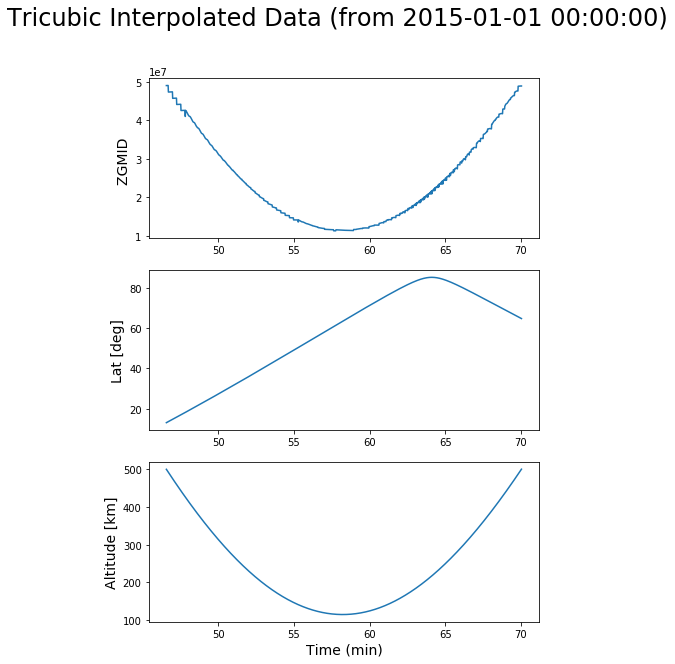

100%|██████████| 1/1 [00:11<00:00, 11.05s/it]


In [8]:
LoadGUI()



